In [ ]:
!pip install pmdarima
!pip install bayesian-optimization
!pip install prophet
!pip install gluonts
!pip install --upgrade mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### UTIL Funcitons

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error

    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """Naive forecasting method which just repeats previous samples"""
    return actual[:-seasonality]


def _relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) / (
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
            + EPSILON
        )

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(
    actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None
):
    """Bounded Relative Error"""
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(
            _error(actual[seasonality:], _naive_forecasting(actual, seasonality))
        )
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """Geometric mean"""
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Root Mean Squared Error"""
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """Mean Error"""
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """Geometric Mean Absolute Error"""
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """Median Absolute Error"""
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """Mean Percentage Error"""
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error

    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0

    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.median(
        2.0
        * np.abs(actual - predicted)
        / ((np.abs(actual) + np.abs(predicted)) + EPSILON)
    )


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error

    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Error"""
    __mae = mae(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted) - __mae)) / (len(actual) - 1)
    )


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """Normalized Absolute Percentage Error"""
    __mape = mape(actual, predicted)
    return np.sqrt(
        np.sum(np.square(_percentage_error(actual, predicted) - __mape))
        / (len(actual) - 1)
    )


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """Root Mean Squared Scaled Error"""
    q = np.abs(_error(actual, predicted)) / mae(
        actual[seasonality:], _naive_forecasting(actual, seasonality)
    )
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """Integral Normalized Root Squared Error"""
    return np.sqrt(
        np.sum(np.square(_error(actual, predicted)))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """Root Relative Squared Error"""
    return np.sqrt(
        np.sum(np.square(actual - predicted))
        / np.sum(np.square(actual - np.mean(actual)))
    )


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Error"""
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """Relative Absolute Error (aka Approximation Error)"""
    return np.sum(np.abs(actual - predicted)) / (
        np.sum(np.abs(actual - np.mean(actual))) + EPSILON
    )


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Relative Absolute Error"""
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Median Relative Absolute Error"""
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Geometric Mean Relative Absolute Error"""
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Mean Bounded Relative Absolute Error"""
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """Unscaled Mean Bounded Relative Absolute Error"""
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """Mean Directional Accuracy"""
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])
        ).astype(int)
    )


def bias(actual: np.ndarray, predicted: np.ndarray):
    """Mean forecast error(or Forecast Bias)"""
    return np.mean(actual - predicted)


METRICS = {
    "mse": mse,
    "rmse": rmse,
    "nrmse": nrmse,
    "me": me,
    "mae": mae,
    "mad": mad,
    "gmae": gmae,
    "mdae": mdae,
    "mpe": mpe,
    "mape": mape,
    "mdape": mdape,
    "smape": smape,
    "smdape": smdape,
    "maape": maape,
    "mase": mase,
    "std_ae": std_ae,
    "std_ape": std_ape,
    "rmspe": rmspe,
    "rmdspe": rmdspe,
    "rmsse": rmsse,
    "inrse": inrse,
    "rrse": rrse,
    "mre": mre,
    "rae": rae,
    "mrae": mrae,
    "mdrae": mdrae,
    "gmrae": gmrae,
    "mbrae": mbrae,
    "umbrae": umbrae,
    "mda": mda,
    "bias": bias,
    "r2": r2_score,
}


def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))


## Actual Code

In [ ]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from prophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

# from utils.metrics import evaluate


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)

2.12.0


# Methods for time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at your data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.

In this section we will show models for both cases, time series with and without extra regressors.

**Prepare data before modeling**

In [ ]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}
city = "Kolkata"
filepath = 'datasets/AQI Values/AQI_avg_'+city+'_value.csv'
air_pollution = pd.read_csv(filepath)
air_pollution['Date'] = pd.to_datetime(air_pollution.Date)
air_pollution = air_pollution.set_index('Date')
# air_pollution.index = pd.to_datetime(air_pollution.index)

air_pollution = air_pollution.replace(0, np.nan)
air_pollution = air_pollution.interpolate(method='time')
air_pollution.head()


,City,PM10,PM25,SO2,NO2,CO,O3,AQI
Date,,,,,,,,
2017-01-01,Kolkata,148.59,NaN,NaN,70.220,1.69,45.05,132.0
2017-01-02,Kolkata,193.84,NaN,NaN,60.225,1.64,51.85,162.0
2017-01-03,Kolkata,153.74,112.9,NaN,50.230,1.72,42.29,276.0
2017-01-04,Kolkata,127.76,105.6,NaN,47.640,0.90,49.29,118.0
2017-01-05,Kolkata,141.19,98.3,NaN,48.440,1.69,40.27,227.0


In [ ]:
air_pollution = air_pollution.drop("City",axis=1)

split_date = '2022-06-30'
df_training = air_pollution.loc[air_pollution.index <= split_date]
df_test = air_pollution.loc[air_pollution.index > split_date]
push_factor = len(df_training)
test_data_size = len(df_test)
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('datasets/training.csv')
df_test.to_csv('datasets/test.csv')

2007 days of training data 
 199 days of testing data 


In [ ]:
air_pollution.head()

,PM10,PM25,SO2,NO2,CO,O3,AQI
Date,,,,,,,
2017-01-01,148.59,NaN,NaN,70.220,1.69,45.05,132.0
2017-01-02,193.84,NaN,NaN,60.225,1.64,51.85,162.0
2017-01-03,153.74,112.9,NaN,50.230,1.72,42.29,276.0
2017-01-04,127.76,105.6,NaN,47.640,0.90,49.29,118.0
2017-01-05,141.19,98.3,NaN,48.440,1.69,40.27,227.0


## Univariate-time-series-forecasting

In this section we will focus on time series forecasting methods capable of only looking at the target variable. This means no other regressors (more variables) can be added into the model.

### Autoregressive integrated moving average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

* Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
* Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

**Tuning ARIMA parameters**

Non stationarity series will require level of differencing (d) >0 in ARIMA
Select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots
AUTOARIMA

Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [ ]:
# ARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.AQI))):
    temp_train = air_pollution[:len(df_training)+t]
    model = ARIMA(temp_train.AQI, order=(1, 0, 0))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.AQI, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 199/199 [00:34<00:00,  5.71it/s]


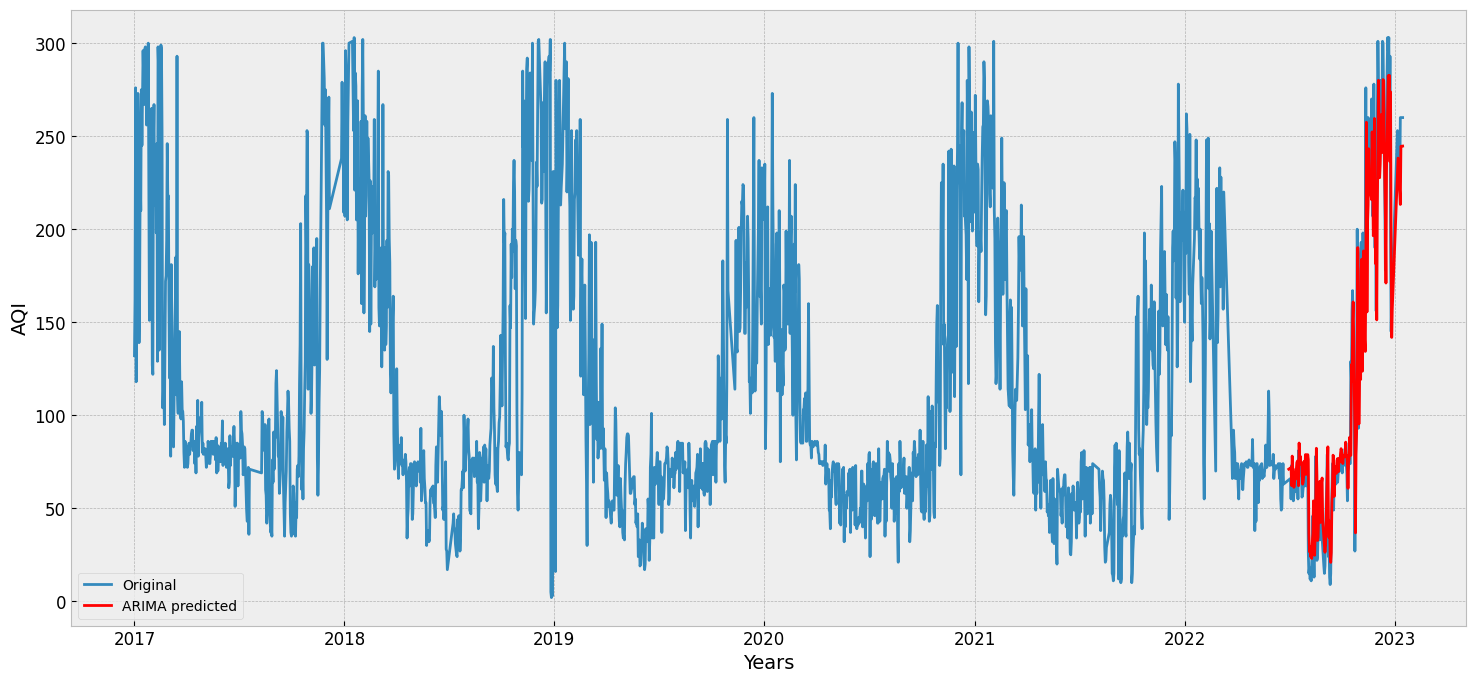

In [ ]:
plt.plot(air_pollution.index, air_pollution.AQI.values, label='Original')
plt.plot(yhat.index,yhat.values, color='red', label='ARIMA predicted')
plt.xlabel("Years")
plt.ylabel("AQI")
plt.legend()

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [ ]:
# SARIMA example

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.AQI))):
    temp_train = air_pollution[:len(df_training)+t]
    model = SARIMAX(temp_train.AQI, order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMA'] = evaluate(df_test.AQI, yhat.values)
predictionsDict['SARIMA'] = yhat.values

100%|██████████| 199/199 [00:09<00:00, 20.85it/s]


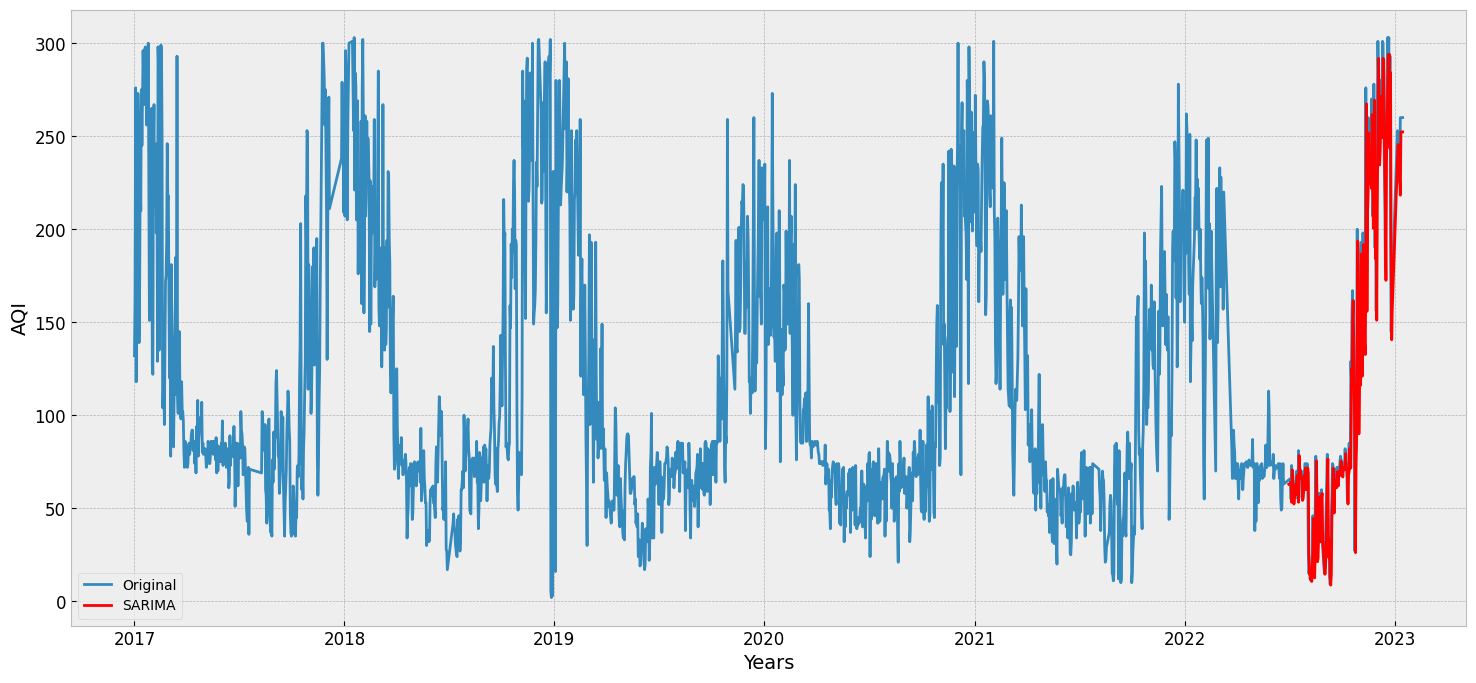

In [ ]:
plt.plot(air_pollution.index, air_pollution.AQI.values, label='Original')
plt.plot(yhat.index, yhat.values, color='red', label='SARIMA')
plt.xlabel("Years")
plt.ylabel("AQI")
plt.legend()

## Multivariate time series forecasting

In [ ]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
df_training = df_training.replace(np.nan,0)
df_test = df_test.replace(np.nan,0)

X_train_df, y_train = create_time_features(
    df_training, target='AQI')

X_test_df, y_test = create_time_features(df_test, target='AQI')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)


### Tree models

#### XGBoost

In [ ]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.AQI, yhat)
predictionsDict['XGBoost'] = yhat

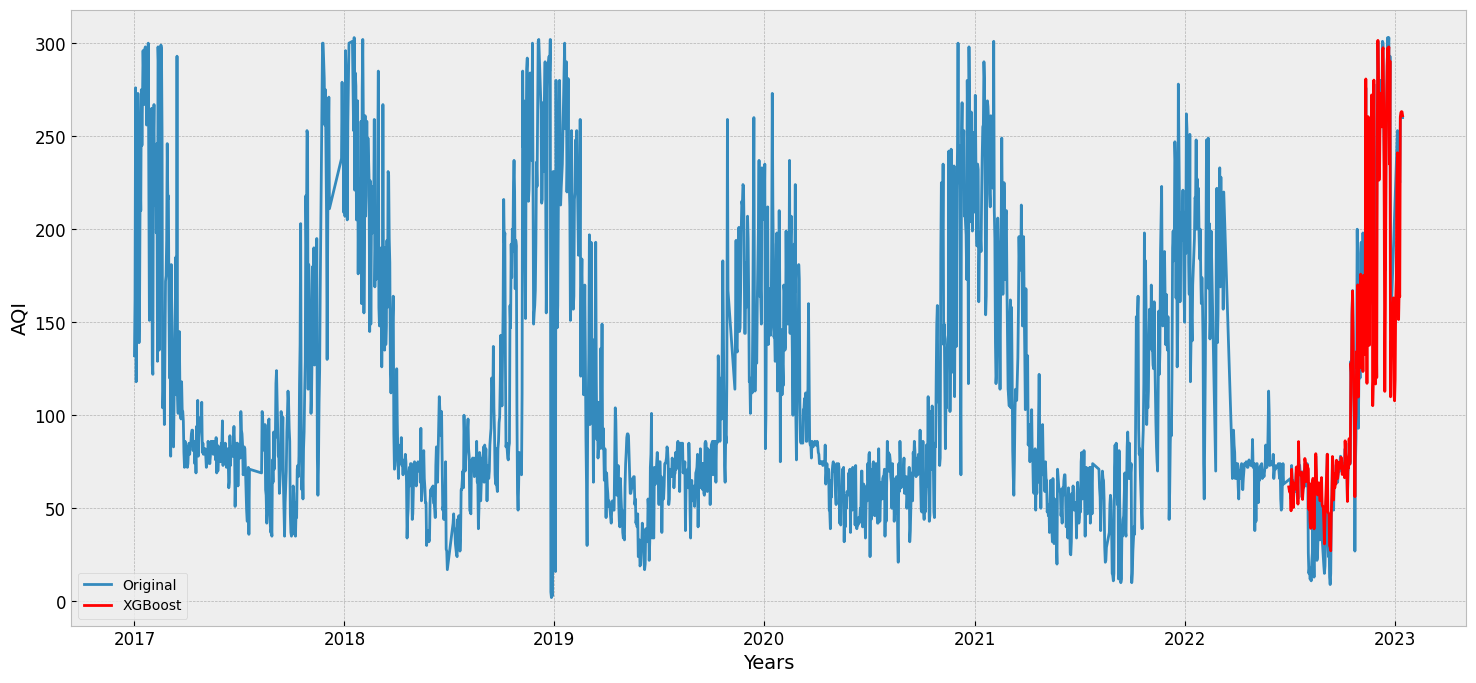

In [ ]:
plt.plot(air_pollution.index, air_pollution.AQI.values, label='Original')
plt.plot(air_pollution.index[-test_data_size::1],yhat, color='red', label='XGBoost')
plt.xlabel("Years")
plt.ylabel("AQI")
plt.legend()

#### Lightgbm

A tree gradient boosting model by [microsoft](https://github.com/microsoft/LightGBM)

In [ ]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['LightGBM'] = evaluate(df_test.AQI, yhat)
predictionsDict['LightGBM'] = yhat

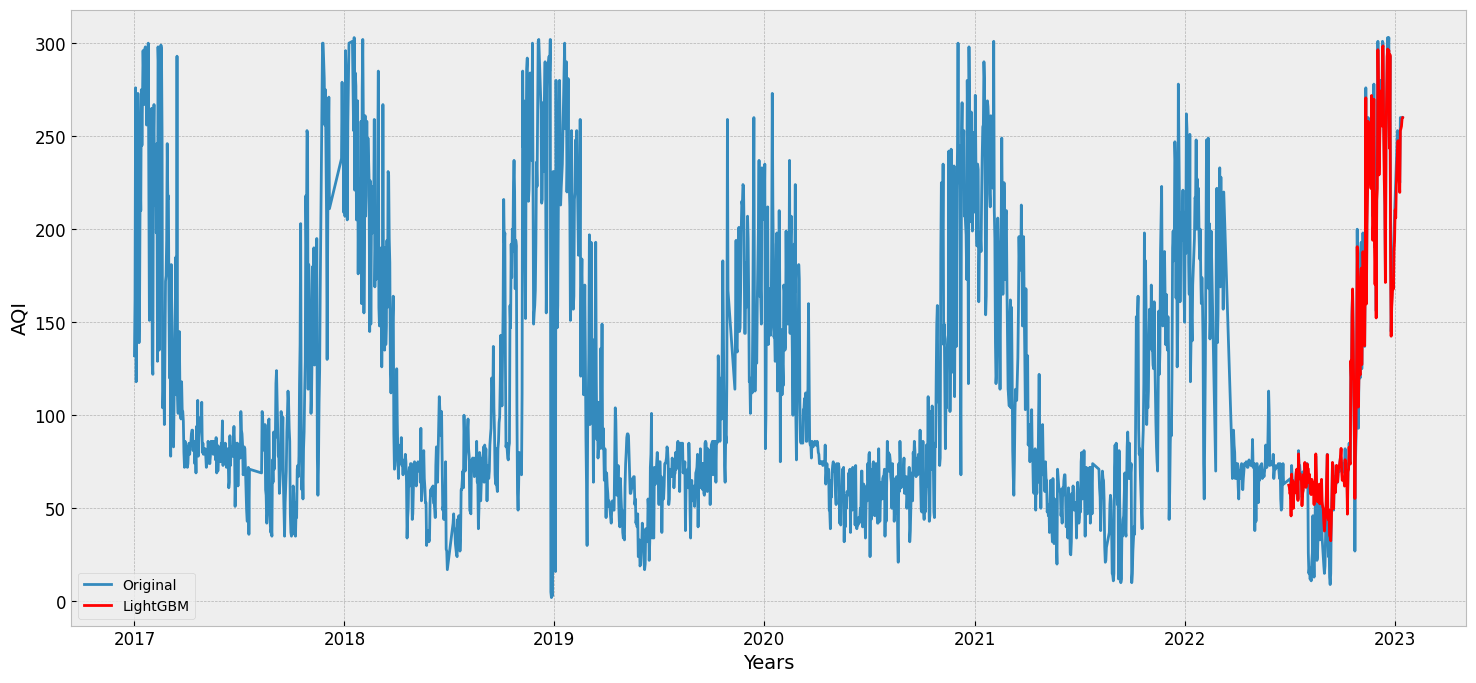

In [ ]:
plt.plot(air_pollution.index, air_pollution.AQI.values, label='Original')
plt.plot(air_pollution.index[-test_data_size::1],yhat, color='red', label='LightGBM')
plt.xlabel("Years")
plt.ylabel("AQI")
plt.legend()

### Deep learning

#### Tensorlfow LSTM

LSTM are a special type of neural network architecture, you can read more on this [here](https://www.tensorflow.org/guide/keras/rnn)

We will be trying a LSTM model for our benchmark but we will need to reshape our data to provide the network a window of previous samples (past days data) for each y target value. Find the code here

In [ ]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [ ]:
dropout = 0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") #Support for tensorboard tracking!
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 100

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/100
200/200 [==============================] - 8s 16ms/step - loss: 34.4018 - val_loss: 41.9894
Epoch 2/100
200/200 [==============================] - 3s 13ms/step - loss: 17.9669 - val_loss: 33.6523
Epoch 3/100
200/200 [==============================] - 2s 12ms/step - loss: 13.8895 - val_loss: 21.9200
Epoch 4/100
200/200 [==============================] - 2s 10ms/step - loss: 11.3049 - val_loss: 20.5513
Epoch 5/100
200/200 [==============================] - 2s 10ms/step - loss: 10.3139 - val_loss: 17.5171
Epoch 6/100
200/200 [==============================] - 2s 10ms/step - loss: 9.3545 - val_loss: 22.3284
Epoch 7/100
200/200 [==============================] - 2s 10ms/step - loss: 8.8212 - val_loss: 12.9716
Epoch 8/100
200/200 [==============================] - 2s 9ms/step - loss: 8.3127 - val_loss: 16.8442
Epoch 9/100
200/200 [==============================] - 2s 11ms/step - loss: 8.0115 - val_loss: 16.8220
Epoch 10/100
200/200 [==============================] - 2s 12ms/step 

In [ ]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['LSTM'] = evaluate(y_test, yhat)
predictionsDict['LSTM'] = yhat

7/7 [==============================] - 1s 3ms/step


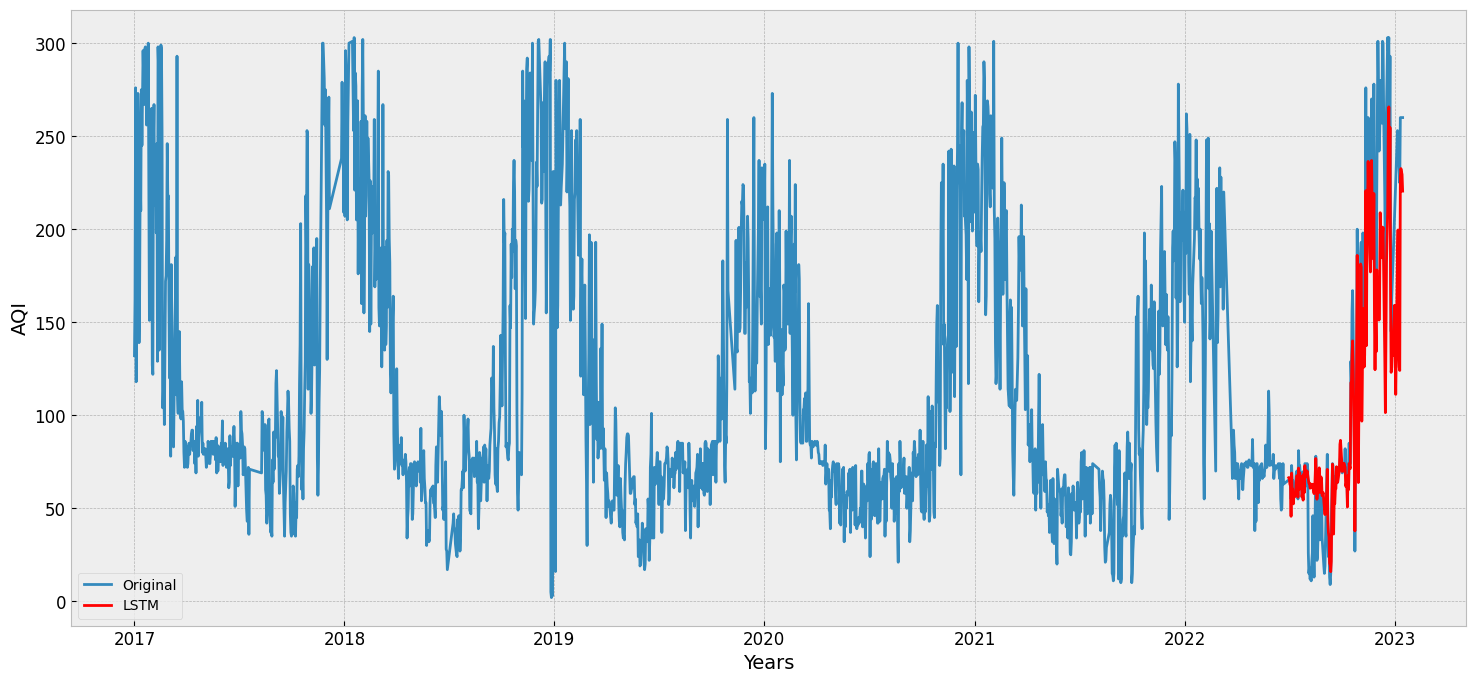

In [ ]:
plt.plot(air_pollution.index, air_pollution.AQI.values, label='Original')
plt.plot(air_pollution.index[-test_data_size::1],yhat, color='red', label='LSTM')
plt.xlabel("Years")
plt.ylabel("AQI")
plt.legend()

# Appendix

## Hyperparameter optimization

### Bayesian processes - Lightgbm

In [ ]:
def rms(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))


my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (2000, 10000),
    'num_leaves': (200, 1500),
    # 'min_data_in_leaf': (0,500),
    'max_depth': (2, 5),
    # 'min_samples_leaf': (1, 4),
    # 'min_samples_split': (2, 10),
}


def lgb_hyper_param(n_estimators,
                    num_leaves,
                    # min_data_in_leaf,
                   max_depth):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    num_leaves = int(num_leaves)
    # min_data_in_leaf = int(min_data_in_leaf)

    clf = lgb.LGBMRegressor(n_estimators=n_estimators,
                            max_depth=int(max_depth),
                            num_leaves = int(num_leaves),
                            # min_data_in_leaf = int(min_data_in_leaf),
                            n_jobs=1,
                            verbosity=-1)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))


optimizer = BayesianOptimization(
    f=lgb_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize(
    init_points=3,
    n_iter=100,
    # acq='ei'
)

|   iter    |  target   | max_depth | n_esti... | num_le... |
-------------------------------------------------------------
| 1         | -0.9486   | 3.251     | 7.763e+03 | 200.1     |
| 2         | -0.9484   | 2.907     | 3.174e+03 | 320.0     |
| 3         | -0.9469   | 2.559     | 4.764e+03 | 715.8     |
| 4         | -0.9486   | 3.128     | 8.319e+03 | 1.207e+03 |
| 5         | -0.9486   | 3.597     | 8.299e+03 | 427.4     |
| 6         | -0.9487   | 3.674     | 4.772e+03 | 718.4     |
| 7         | -0.9483   | 2.683     | 3.245e+03 | 1.431e+03 |
| 8         | -0.9526   | 4.179     | 7.829e+03 | 453.1     |
| 9         | -0.9454   | 2.143     | 7.759e+03 | 208.5     |
| 10        | -0.9526   | 4.866     | 7.313e+03 | 811.9     |
| 11        | -0.9455   | 2.583     | 7.742e+03 | 208.9     |
| 12        | -0.9453   | 2.967     | 8.108e+03 | 1.314e+03 |
| 13        | -0.9526   | 4.565     | 7.755e+03 | 1.386e+03 |
| 14        | -0.9526   | 4.031     | 6.383e+03 | 698.2     |
| 15    

In [ ]:
params = optimizer.max['params']

# Converting the max_depth and n_estimator values from float to int
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
# params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
params['num_leaves'] = int(params['num_leaves'])

# Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_lgb = lgb.LGBMRegressor(**params)
# Change verbose to True if you want to see it train
tunned_lgb.fit(X_train, y_train)

yhat = tunned_lgb.predict(X_test)
resultsDict['LightGBM Optimized'] = evaluate(y_test, yhat)

In [ ]:
increase = 1 - (resultsDict['LightGBM Optimized']
                ['rmse']/resultsDict['LightGBM']['rmse'])
print(
    f"Bayesian optimized LightGBM is {increase*100}% better than the LightGBM with default parameters")

Bayesian optimized LightGBM is -34.41993112555384% better than the LightGBM with default parameters


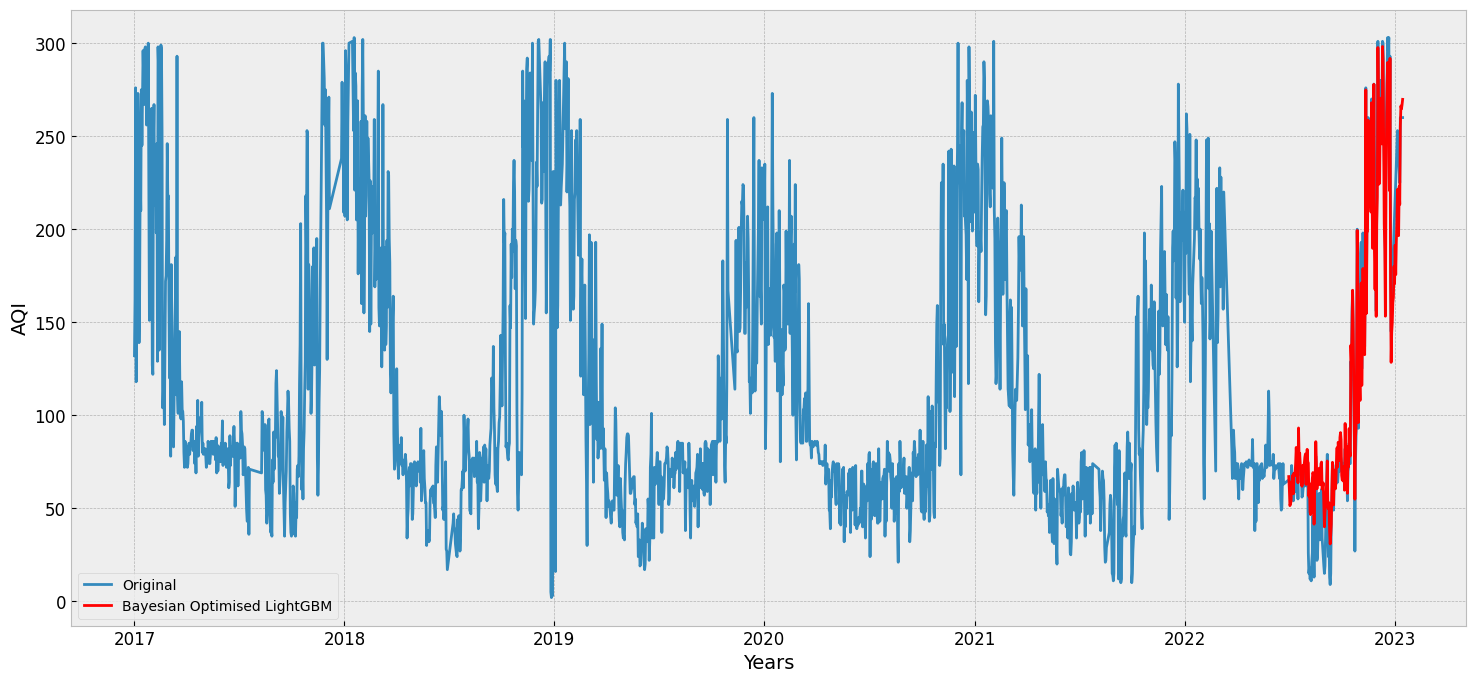

In [ ]:
plt.plot(air_pollution.index, air_pollution.AQI.values, label='Original')
plt.plot(air_pollution.index[-test_data_size::1],yhat, color='red', label='Bayesian Optimised LightGBM')
plt.xlabel("Years")
plt.ylabel("AQI")
plt.legend()

In [ ]:

with open('results/'+city+'/'+city+'_scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('results/'+city+'/'+city+'_predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Values updated")

Values updated
